In [1]:
import tensorflow as tf
from tensorflow import keras

### Simple Food Classifcation model

In [2]:
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from os.path import exists
from collections import defaultdict

def load_data(file_path, base_dir, max_per_class=None):
    image_paths = defaultdict(list)
    labels = []
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.split('/')
            class_name = parts[0].strip()
            img_path = f"{base_dir}/{class_name}/{parts[1].strip()}"
            image_paths[class_name].append(img_path)
    
    # Restrict the number of images per class
    final_image_paths = []
    final_labels = []
    for class_name, paths in image_paths.items():
        if max_per_class:
            paths = paths[:max_per_class]  # Limit to max_per_class images
        final_image_paths.extend(paths)
        final_labels.extend([class_name] * len(paths))
    
    return final_image_paths, final_labels

def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        img_path = img_path + '.jpg'
        if not exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue
        img = Image.open(img_path)
        img = img.convert('RGB')  # Ensure all images are in RGB mode
        img = img.resize(target_size)
        img_array = np.array(img)
        
        # Check if the image shape is correct
        if img_array.shape != (target_size[0], target_size[1], 3):
            print(f"Unexpected image shape: {img_array.shape} for image {img_path}")
            continue
        
        images.append(img_array)
    return np.array(images)

# Load training and testing data with fewer files per class
train_image_paths, train_labels = load_data(
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/meta/train.txt',
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images',
    max_per_class=80  # Take at most 50 images per class
)
test_image_paths, test_labels = load_data(
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/meta/test.txt',
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images',
    max_per_class=20  # Take at most 20 images per class
)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Preprocess images
#print('train_image_paths:', train_image_paths)
train_images = load_and_preprocess_images(train_image_paths)
test_images = load_and_preprocess_images(test_image_paths)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert to NumPy arrays for model input
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels_encoded = np.array(train_labels_encoded)
test_labels_encoded = np.array(test_labels_encoded)

print(f"Classes: {label_encoder.classes_}")


Classes: ['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheese_plate' 'cheesecake' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros' 'clam_chowder' 'club_sandwich' 'crab_cakes' 'creme_brulee'
 'croque_madame' 'cup_cakes' 'deviled_eggs' 'donuts' 'dumplings' 'edamame'
 'eggs_benedict' 'escargots' 'falafel' 'filet_mignon' 'fish_and_chips'
 'foie_gras' 'french_fries' 'french_onion_soup' 'french_toast'
 'fried_calamari' 'fried_rice' 'frozen_yogurt' 'garlic_bread' 'gnocchi'
 'greek_salad' 'grilled_cheese_sandwich' 'grilled_salmon' 'guacamole'
 'gyoza' 'hamburger' 'hot_and_sour_soup' 'hot_dog' 'huevos_rancheros'
 'hummus' 'ice_cream' 'lasagna' 'lobster_bisque' 'lobster_roll_sandwich'
 'macaroni_and_cheese' 'macarons' 'miso_soup' 'mussels' 'nachos'
 'omelette' 'onion_r

In [3]:
## using the data in a Tensorflow tensor
import tensorflow as tf
# Define a data augmentation function
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop (adjust size as needed)
    return image, label

# Apply data augmentation to the training dataset
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels_encoded))
    .map(lambda x, y: (tf.image.resize(x, [224, 224]), y))  # Resize images to 224x224
    .map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Preprocess the test dataset (no augmentation for testing)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_labels_encoded))
    .map(lambda x, y: (tf.image.resize(x, [224, 224]), y))  # Resize images to 224x224
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [4]:
from tensorflow.keras import optimizers, models
def create_model():
    import tensorflow as tf
    
    # Build a Sequential model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        
        # First conv block
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Second conv block
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Third conv block
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Fourth conv block
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Fifth conv block
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(101, activation='softmax')
    ])
    
    return model


model = create_model()

model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history_improved = model.fit(train_dataset,
                                      validation_data=test_dataset,
                                      epochs=30)


Epoch 1/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.0828 - loss: 7.1035 - val_accuracy: 0.0144 - val_loss: 6.1189
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.0700 - loss: 6.5992 - val_accuracy: 0.0332 - val_loss: 6.1133
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.0801 - loss: 5.6018 - val_accuracy: 0.0391 - val_loss: 5.8128
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.1077 - loss: 4.5241 - val_accuracy: 0.0436 - val_loss: 5.4260
Epoch 5/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.1451 - loss: 3.9575 - val_accuracy: 0.0540 - val_loss: 5.3630
Epoch 6/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.1707 - loss: 3.5779 - val_accuracy: 0.0668 - val_loss: 4.9084
Epoch 7/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.2151 - loss: 3.2716 - val_accuracy: 0.0649 - val_loss: 4.9142
Epoch 8/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.2566 - loss: 2.9852 - val_accu

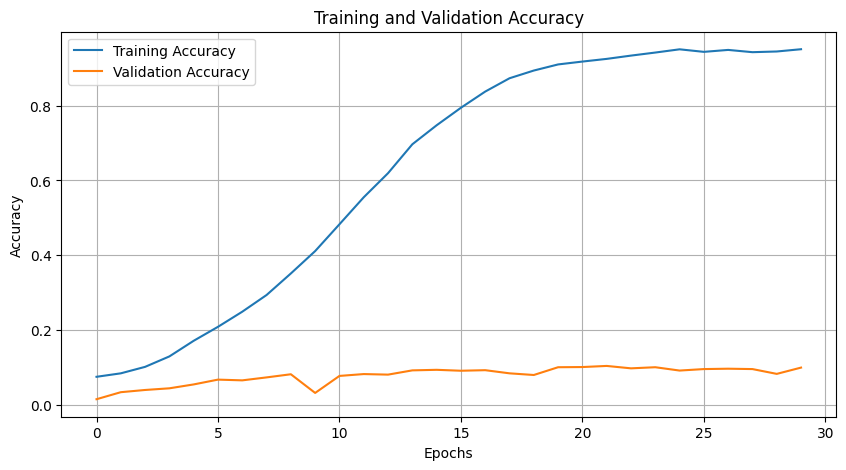

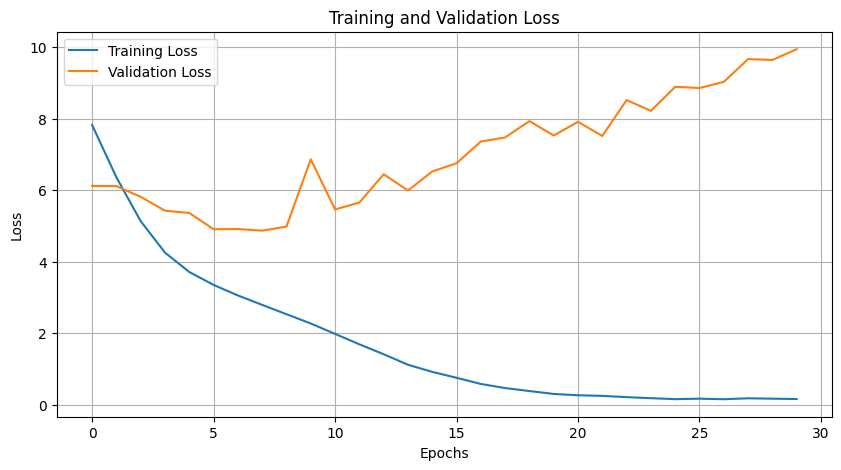

In [5]:
import matplotlib.pyplot as plt
train_acc = history_improved.history['accuracy']
val_acc = history_improved.history['val_accuracy']
train_loss = history_improved.history['loss']
val_loss = history_improved.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [6]:
print(history_improved.history)
model.save('food_model1.h5')


{'accuracy': [0.07438118755817413, 0.08366336673498154, 0.10099010169506073, 0.12896040081977844, 0.17079207301139832, 0.20816831290721893, 0.24863861501216888, 0.2933168411254883, 0.35099008679389954, 0.4108910858631134, 0.4826732575893402, 0.554950475692749, 0.6194307208061218, 0.6967821717262268, 0.7476485371589661, 0.7945544719696045, 0.8378713130950928, 0.8735148310661316, 0.8941831588745117, 0.9105197787284851, 0.9181930422782898, 0.9253712892532349, 0.934158444404602, 0.9423267245292664, 0.9509900808334351, 0.9441831707954407, 0.9493811726570129, 0.9433168172836304, 0.9451732635498047, 0.9512376189231873], 'loss': [7.818368911743164, 6.356975555419922, 5.13240909576416, 4.254878520965576, 3.713446617126465, 3.353088617324829, 3.058783769607544, 2.795863151550293, 2.534938097000122, 2.275745391845703, 1.9852441549301147, 1.6942795515060425, 1.4169238805770874, 1.123909831047058, 0.9246748685836792, 0.7591716647148132, 0.5872018337249756, 0.47191014885902405, 0.3891988694667816, 0

Test accuracy: 0.0990


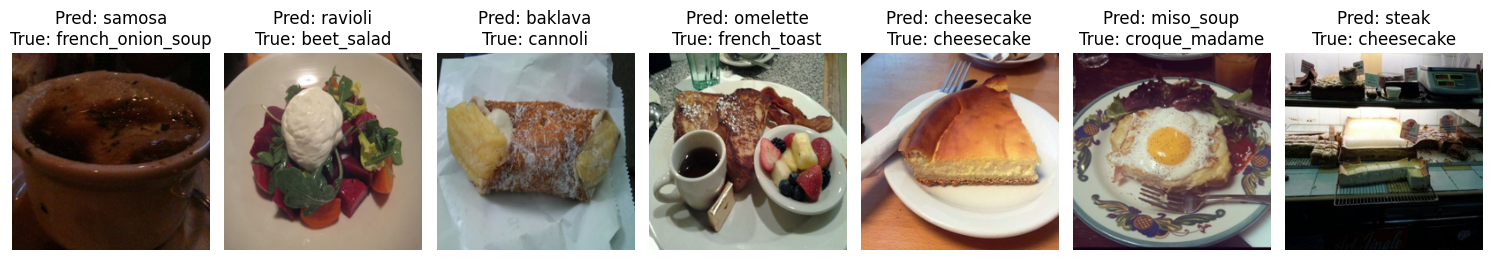

In [9]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # Resize to model's input size
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = tf.image.per_image_standardization(img_array)  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the TensorFlow model
    predictions = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(predictions.squeeze())  # Remove batch dimension and get max index

    return class_labels[predicted_index]

def show_and_predict_dataset_images(dataset, model, class_labels, num_images=3):
    # Create an unbatched dataset
    
    # Create a list to store samples
    samples = []
    
    # Extract samples from the dataset
    shuffled_dataset = dataset.unbatch().shuffle(buffer_size=1000)  # Adjust buffer size as needed

    # Extract a random subset of images and labels
    for image, label in shuffled_dataset.take(num_images):
        samples.append((image.numpy(), label.numpy()))
    
    # Create subplot
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axs = [axs]  # Make axs iterable when only one image

    for i, (image_array, true_label) in enumerate(samples):
        # Handle different possible input shapes
        if len(image_array.shape) > 3:
            image_array = tf.squeeze(image_array)
        
        # Create a copy for display
        display_image = image_array.copy()
        
        # Denormalize if necessary
        if display_image.max() <= 1.0:
            display_image = (display_image * 255).astype(np.uint8)
        
        # Prepare image for model prediction
        preprocessed_image = tf.convert_to_tensor(image_array)
        preprocessed_image = tf.expand_dims(preprocessed_image, 0)  # Add batch dimension
        
        # Make prediction
        predictions = model.predict(preprocessed_image, verbose=0)
       # print(predictions[0])
        ## find max value of the prediction[0] array
        predicted_idx = np.argmax(predictions[0])
       # print(predicted_idx)

        
        # Get class labels
        predicted_label = class_labels[predicted_idx]
        true_class = class_labels[true_label]
        
        # Display image and predictions
        axs[i].imshow(display_image)
        axs[i].set_title(f'Pred: {predicted_label}\nTrue: {true_class}')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get class labels
classes = label_encoder.classes_

# Show predictions
show_and_predict_dataset_images(test_dataset, model, classes, num_images=7)